In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import PIL
import math
from tqdm import tqdm
from torch import nn
from torch.nn import functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from random import randint

In [2]:
white = 255
black = 0

def inverse_color(img):
    return PIL.Image.eval(img, lambda val: 255 - val)

def fix_background_color_bug(img):
    colors = sorted(img.getcolors(), key=lambda pair: pair[0], reverse=True)
    replace_color = colors[0][1]
    remove_color = colors[2][1] if colors[2][1] < colors[1][1] else colors[1][1]

    data = np.array(img)
    data[data == remove_color] = replace_color
    return PIL.Image.fromarray(data)

def remove_background(img):
    return PIL.Image.eval(img, lambda val: 0 if val < (256/2) else val)

def to_binary(img):
    return PIL.Image.eval(img, lambda val: 255 if val < (256/2) else 0)

In [3]:
binary_image = True


## Rotation, Brightness and Resizing
random_transforms = [
    transforms.RandomRotation(360, fill=black),
    transforms.RandomAffine(0, shear=15, scale=(0.8, 0.95), translate=(.03, .03)),
]

format_transforms = [
    transforms.Resize((40, 40)),
]

if not binary_image:
    random_transforms.append(transforms.ColorJitter(brightness=(0.9, 1), contrast=(0.7, 1)))
else:
    format_transforms.append(transforms.Lambda(to_binary))

all_transforms = transforms.Compose(random_transforms + format_transforms)
format_transforms = transforms.Compose(format_transforms)

## Adding Grayscale + Inverse color to operators
operators_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Lambda(inverse_color),
    # Randomly scale up and down
#     transforms.RandomAffine(0, scale=(0.9, 1.1), fillcolor=white),
    all_transforms,
])

video_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Lambda(inverse_color),
    transforms.Lambda(remove_background),
    format_transforms,
])

operators_tensor_transform = transforms.Compose([
    operators_transform,
    transforms.ToTensor(),
])

minst_tensor_transform = transforms.Compose([
    all_transforms,
    transforms.ToTensor(),
])

video_tensor_transform = transforms.Compose([
    video_transform,
    transforms.ToTensor(),
])

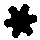

In [4]:
op_video_dataset = datasets.ImageFolder(root='video_dataset/op', transform=video_tensor_transform)
minst_video_dataset = datasets.ImageFolder(root='video_dataset/minst', transform=video_tensor_transform)
datasets.ImageFolder(root='video_dataset/op', transform=video_transform)[2][0]

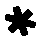

In [5]:
# Operators Dataset
operators_dataset = datasets.ImageFolder(root='operators', transform=operators_tensor_transform)

# Show exemple image
datasets.ImageFolder(root='operators', transform=operators_transform)[4][0]

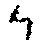

In [6]:
# Minst Dataset
minst_dataset = datasets.MNIST("", transform=minst_tensor_transform, download=True)

# Show example image
datasets.MNIST("", transform=all_transforms, download=True)[0][0]

In [7]:
def get_stats(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=50,
                                             shuffle=False, num_workers=2)
    mean = 0.
    std = 0.
    for images, _ in loader:
        batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(loader.dataset)
    std /= len(loader.dataset)

    return mean, std

In [8]:
operators_mean, operators_std = get_stats(operators_dataset)
operators_mean, operators_std

(tensor([0.7462]), tensor([0.4280]))

In [9]:
minst_mean, minst_std = get_stats(minst_dataset)
minst_mean, minst_std

(tensor([0.9006]), tensor([0.2933]))

In [10]:
class FusionDataset(datasets.VisionDataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, operators_dataset, minst_dataset, video_dataset=[]):
        self.operators_dataset = operators_dataset
        self.minst_dataset = minst_dataset
        self.video_dataset = video_dataset

    def __getitem__(self, index):
        if index < len(self.video_dataset):
            tensor, class_index = self.video_dataset[index]   
            tensor = transforms.Normalize(operators_mean, operators_std)(tensor)
            
            # Get actual index
            class_str = self.video_dataset.classes[class_index]
            new_index = self.classes.index(class_str)
            
            return tensor, new_index
        elif index < len(self.video_dataset) + len(self.operators_dataset):
            tensor, class_index = self.operators_dataset[index - len(self.video_dataset)]   
            tensor = transforms.Normalize(operators_mean, operators_std)(tensor)
            return tensor, class_index + len(self.minst_dataset.classes)
        elif index < len(self.video_dataset) + len(self.operators_dataset) + len(self.minst_dataset):
            tensor, class_index = self.minst_dataset[index - len(self.operators_dataset) - len(self.video_dataset)]
            tensor = transforms.Normalize(minst_mean, minst_std)(tensor)
            return tensor, class_index
        else:
            random_index = randint(0, len(self.operators_dataset)-1)
            tensor, class_index = self.operators_dataset[random_index]
            tensor = transforms.Normalize(operators_mean, operators_std)(tensor)
            return tensor, class_index + len(self.minst_dataset.classes)
        
    def __len__(self):
        return len(self.minst_dataset) + len(self.operators_dataset)
    
    @property
    def classes(self):
        minst_classes = [s[:1] for s in self.minst_dataset.classes]
        return minst_classes + self.operators_dataset.classes
    
    @property
    def targets(self):
        video_tar = self.video_dataset.targets if self.video_dataset else []
        op_tar = [tar+len(self.minst_dataset.classes) for tar in self.operators_dataset.targets]
        return  list(self.minst_dataset.targets.numpy()) + op_tar
    
def make_weights_for_balanced_classes(targets, nclasses):  
    count = [0] * nclasses                                                      
    for target in targets:                                                         
        count[target] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(targets)                                              
    for idx, target in enumerate(targets):                                          
        weight[idx] = weight_per_class[target]                                  
    return weight 
    
def balanced_loader(dataset, batch_size=100, validation_split=0.2, shuffle_dataset=True):                                                                    
    # For unbalanced dataset we create a weighted sampler                       
    weights = make_weights_for_balanced_classes(dataset.targets, len(dataset.classes))                                                                
    weights = torch.DoubleTensor(weights)                                       
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                     

    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=sampler)

In [11]:
dataset = FusionDataset(operators_dataset, minst_dataset, [])
# mean, std = get_stats(dataset)
# mean, std

In [12]:
dataset.classes

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'divide',
 'equal',
 'minus',
 'multiply',
 'plus']

In [13]:
class NormalizedDataset:
    
    def __init__(self, dataset):
        self.dataset = dataset
        self.mean, self.std = get_stats(self.dataset)
        
    def __getitem__(self, index):
        tensor, class_ = self.dataset[index]
        normalized = transforms.Normalize(mean=self.mean, std=self.std)(tensor)
        return normalized, class_
    
    def __len__(self):
        return len(self.dataset)
    
class IncompleteDataset:
    
    def __init__(self, dataset, all_classes):
        self.dataset = dataset
        self.all_classes = all_classes
        self.mean, self.std = get_stats(self.dataset)
        
    def __getitem__(self, index):
        tensor, class_ = self.dataset[index]
        class_str = self.dataset.classes[class_]
        new_index = self.all_classes.index(class_str)
        normalized = transforms.Normalize(mean=self.mean, std=self.std)(tensor)
        return normalized, new_index

    def __len__(self):
        return len(self.dataset)
    
op_incomplete_dataset = IncompleteDataset(op_video_dataset, operators_dataset.classes)
minst_incomplete_dataset = IncompleteDataset(minst_video_dataset, minst_dataset.classes)

In [14]:
train_loader = torch.utils.data.DataLoader(NormalizedDataset(operators_dataset), batch_size=100)
test_loader = torch.utils.data.DataLoader(op_incomplete_dataset, batch_size=100)
len(train_loader.dataset), len(test_loader.dataset)

(6, 4)

In [15]:
# from keras.regularizers import L1L2
# from keras.layers import Conv2D
# Creating a Net class object, which consists of 2 convolutional layers, max-pool layers and fully-connected layers
class Conv_Net(nn.Module):
    
    def __init__(self, nb_hidden=50):        
        super(Conv_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)  # the first convolutional layer, which processes the input image
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)  # the second convolutional layer, which gets the max-pooled set
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)  # the second convolutional layer, which gets the max-pooled set

        self.fc1 = nn.Linear(576, nb_hidden)  # the first fully-connected layer, which gets flattened max-pooled set
        self.fc2 = nn.Linear(nb_hidden, 15)  # the second fully-connected layer that outputs the result

    # Creating the forward pass
    def forward(self, x):
        
        # The first two layers
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
        
#         x = nn.Dropout(p=0.5)(x)
        
        # The second two layers
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2)) 
        
#         x = nn.Dropout(p=0.5)(x)
        
        x = F.relu(F.max_pool2d(self.conv3(x), kernel_size=2)) 

        # Flattening the data set for fully-connected layer
        x = x.view(x.size(0), -1)
    
        # The first fully-connected layer
        x = F.relu(self.fc1(x))
        
        x = nn.Dropout(p=0.3)(x)
        
        # The second full-connected layer
        x = self.fc2(x)
        
        return x

In [17]:
%%time

model = Conv_Net()

losses = []
test_losses = []

# Defining the optimizer for GD
lr = 3e-4
optimizer = torch.optim.Adam(model.parameters(), lr = lr) 

# Defining the criterion to calculate loss
criterion = nn.CrossEntropyLoss()

# Train the model
nb_epochs = 30000


for e in range(nb_epochs):
    # Train the input dataset by dividing it into mini_batch_size small datasets
    acc = 0
    for train_input, train_target in train_loader:

        # Model computations
        output = model(train_input)
        loss = criterion(output, train_target) 
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        
        tmp_acc = 0
        for tensor, target in zip(output, train_target):
            _, index = tensor.max(0)
            if index == target:
                tmp_acc += 1
                
        tmp_acc /= len(output)
        acc += tmp_acc 
        
    acc /= len(train_loader)
    
    should_print = e%101 == 0
    if should_print:
        print('%dth epoch, test_acc: %f' % (e+1, acc), end="")
    losses.append(loss)
    
    # Train the input dataset by dividing it into mini_batch_size small datasets
    acc = 0
    for test_input, test_target in test_loader:
        
        output = model(test_input)
        loss = criterion(output, test_target) 
        
        tmp_acc = 0
        for tensor, target in zip(output, test_target):
            _, index = tensor.max(0)
            if index == target:
                tmp_acc += 1
            elif should_print:
                print(", {} != {}".format(index, target), end="")
                
        tmp_acc /= len(output)
        acc += tmp_acc 
                
    acc /= len(test_loader)
    if should_print:
        print(", test acc: %f" % (acc))
    test_losses.append(loss)

1th epoch, test_acc: 0.000000, 5 != 0, 5 != 1, 2 != 3, 2 != 4, test acc: 0.000000
102th epoch, test_acc: 0.166667, 4 != 0, 3 != 1, 4 != 3, 0 != 4, test acc: 0.000000
203th epoch, test_acc: 1.000000, 2 != 0, test acc: 0.750000
304th epoch, test_acc: 1.000000, 2 != 4, test acc: 0.750000
405th epoch, test_acc: 1.000000, test acc: 1.000000
506th epoch, test_acc: 1.000000, test acc: 1.000000
607th epoch, test_acc: 1.000000, test acc: 1.000000
708th epoch, test_acc: 1.000000, test acc: 1.000000
809th epoch, test_acc: 1.000000, test acc: 1.000000
910th epoch, test_acc: 1.000000, test acc: 1.000000
1011th epoch, test_acc: 1.000000, test acc: 1.000000
1112th epoch, test_acc: 1.000000, test acc: 1.000000


KeyboardInterrupt: 

In [ ]:
get_stats(incomplete_dataset)

In [ ]:
loader = torch.utils.data.DataLoader(incomplete_dataset, batch_size=10)

In [ ]:
acc = 0
for test_input, test_target in loader:

    output = model(test_input)
    loss = criterion(output, test_target) 

    tmp_acc = 0
    for tensor, target in zip(output, test_target):
#         print(tensor, target)
        _, index = tensor.max(0)
#         print(tensor, index)
        if index == target:
            tmp_acc += 1

    tmp_acc /= len(output)
    acc += tmp_acc 

acc /= len(test_loader)
print("test loss: %f, acc: %f" % (loss, acc))

In [ ]:
operators_dataset.classes

In [161]:
incomplete_dataset[15][1]

IndexError: list index out of range

In [104]:
image.show()

In [108]:
video_dataset[i][0].numpy()

array([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
         0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
         0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
         0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
         0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.